# Transer Learning

## Settting up

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam

# set up the optimizer
optimizer = Adam()

# set up the hyperparameters
batch_size = 32
epochs = 20
img_size = 64
n_channels = 3
n_hidden = 256

## VGG16

In [2]:
from keras.applications.vgg16 import VGG16

# load the VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, n_channels))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

## CIFAR10

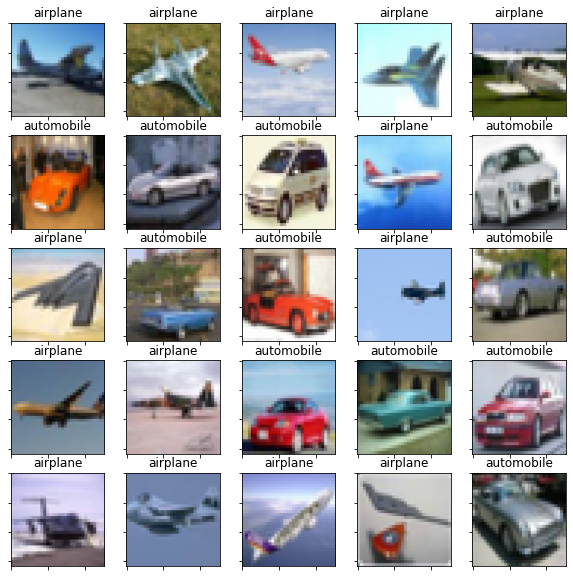

In [3]:
# import the CIFAR10 dataset
from keras.datasets import cifar10

# load the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# extract the data only for the classes 0 and 1
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
x_train = x_train[y_train <= 1]
y_train = y_train[y_train <= 1]
x_test = x_test[y_test <= 1]
y_test = y_test[y_test <= 1]

# zoom in on the images from 32x32 to 64x64
x_train = np.repeat(x_train, 2, axis=1)
x_train = np.repeat(x_train, 2, axis=2)
x_test = np.repeat(x_test, 2, axis=1)
x_test = np.repeat(x_test, 2, axis=2)

# show the 25 images and their labels labeld as "airplane" or "automobile" randomly selected from the training set
n_images = 25
random_indices = np.random.randint(0, len(x_train), n_images)
target_labels = np.array(['airplane', 'automobile'])
plt.figure(figsize=(10, 10))
for i in range(n_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[random_indices[i]])
    plt.title(target_labels[y_train[random_indices[i]]])
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.show()

## Build Model

In [4]:
# add the Dense layers on top of the VGG16 model
model = Sequential()
model.add(vgg16)

model.add(Flatten())
model.add(Dense(n_hidden, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# train only the blocks 5 of the VGG16 model
for layer in vgg16.layers:
    if layer.name.startswith('block5_conv'):
        layer.trainable = True
    else:
        layer.trainable = False

# compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 15,239,489
Trainable params: 7,604,225
Non-trainable params: 7,635,264
_________________________________________________________________


# Train

In [5]:
# introduce data augmentation to the training set
from keras.preprocessing.image import ImageDataGenerator

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True)
datagen.fit(x_train)

# train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/20
313/313 [==============================] - 26s 63ms/step - loss: 0.2601 - accuracy: 0.9030 - val_loss: 0.0958 - val_accuracy: 0.9680
Epoch 2/20
313/313 [==============================] - 17s 53ms/step - loss: 0.1464 - accuracy: 0.9473 - val_loss: 0.0645 - val_accuracy: 0.9770
Epoch 3/20
313/313 [==============================] - 18s 57ms/step - loss: 0.1213 - accuracy: 0.9557 - val_loss: 0.0990 - val_accuracy: 0.9650
Epoch 4/20
313/313 [==============================] - 17s 54ms/step - loss: 0.1143 - accuracy: 0.9589 - val_loss: 0.1040 - val_accuracy: 0.9680
Epoch 5/20
313/313 [==============================] - 17s 55ms/step - loss: 0.1120 - accuracy: 0.9619 - val_loss: 0.0986 - val_accuracy: 0.9675
Epoch 6/20
313/313 [==============================] - 18s 57ms/step - loss: 0.0960 - accuracy: 0.9679 - val_loss: 0.0686 - val_accuracy: 0.9815
Epoch 7/20
313/313 [==============================] - 17s 53ms/step - loss: 0.1018 - accuracy: 0.9647 - val_loss: 0.0748 - val_accuracy:

## History

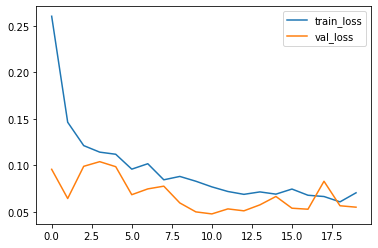

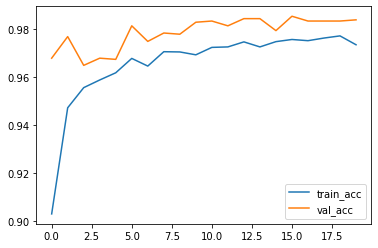

In [6]:
# plot the training and validation accuracy and loss

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(np.arange(epochs), train_loss, label='train_loss')
plt.plot(np.arange(epochs), val_loss, label='val_loss')
plt.legend()
plt.show()

plt.plot(np.arange(epochs), train_acc, label='train_acc')
plt.plot(np.arange(epochs), val_acc, label='val_acc')
plt.legend()
plt.show()